In [1]:
import pandas as pd # standard
import numpy as np # standard
from sklearn import tree # package to make decision tree
from sklearn.metrics import accuracy_score # for accuracy calculation
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

import thermogram_utilities

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel("/Users/avery/OneDrive/Documents/GitHub/Clinical_TLB_2023-2024/lung_cancer_tlb.xlsx")

# replace NA with control
df['CancerType'] = np.where(df['CancerType'].isna(), 'Control', df['CancerType'])

# get location of cut off values
lower_column_index = df.columns.get_loc("T50")
upper_column_index = df.columns.get_loc("T85.1")
label_column_index = df.columns.get_loc("CancerType")

column_indices = np.arange(lower_column_index, upper_column_index)
column_indices = np.append(column_indices, 0)
column_indices = np.append(column_indices, 1)



column_indices = np.append(column_indices, label_column_index)

df = df.iloc[:, column_indices]

# keep only Control and Adenocarcinoma for analysis
df_tree = df[(df['CancerType'] == 'Control') | (df['CancerType'] == 'Adenocarcinoma')]
df_tree = df_tree.reset_index(drop=True)

In [3]:
temps = df_tree.drop(['CancerType', 'sample_id', 'pub_id'], axis = 1).columns.str.replace('T', '')
temps = temps.astype(float)
feature_importance = pd.DataFrame({"Temperature":temps})

# length of df
num_rows = df_tree.shape[0]

# number of bootstraps
total_bootstraps = 100

# create results df
performance_metrics = pd.DataFrame(columns=['Weighted Accuracy', 'AUC'])

# create array of all indices in full data set
all_indices = np.arange(num_rows)

# columns to drop
drop_cols = ['sample_id', 'pub_id', 'CancerType']

# loop to bootstrap and validate many times
for i in range(total_bootstraps):

    # sample indices with replacement of df
    train_indices = np.random.choice(num_rows, num_rows, replace = True)

    # get the train set using the indices
    train_set = df_tree.iloc[train_indices, : ]

    # get the indices not selected
    test_indices = np.setdiff1d(all_indices, train_indices)

    # use not selected indices as the train set
    test_set = df_tree.iloc[test_indices, : ]
    
    # train decision tree
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit( train_set.drop(drop_cols, axis = 1), train_set['CancerType'])

    # get probabilities
    test_probabilities = clf.predict_proba(test_set.drop(drop_cols, axis = 1))

    # test decision tree
    test_predictions = clf.predict(test_set.drop(drop_cols, axis = 1))

    # calculate weighted accuracy
    balanced_acc = balanced_accuracy_score(test_set['CancerType'], test_predictions)

    # calculate AUC
    auc = roc_auc_score(test_set['CancerType'] == 'Control', test_probabilities[:, 1])

    # append accuracy, auc to results df
    performance_metrics.loc[len(performance_metrics)] = [balanced_acc, auc]

    feature_importance_tree = clf.feature_importances_

    feature_importance[i] = feature_importance_tree




In [4]:
df_long = pd.melt(df_tree, id_vars=['sample_id', 'pub_id', 'CancerType'], var_name='temp', value_name='dsp' )

median_df = thermogram_utilities.median_curve(df_long, 'CancerType', 'temp', 'dsp')

median_df['temperature'] = median_df['temperature'].str.replace('T', '').astype(float)

Text(0.5, 1.0, 'Median Lung Cancer Thermograms')

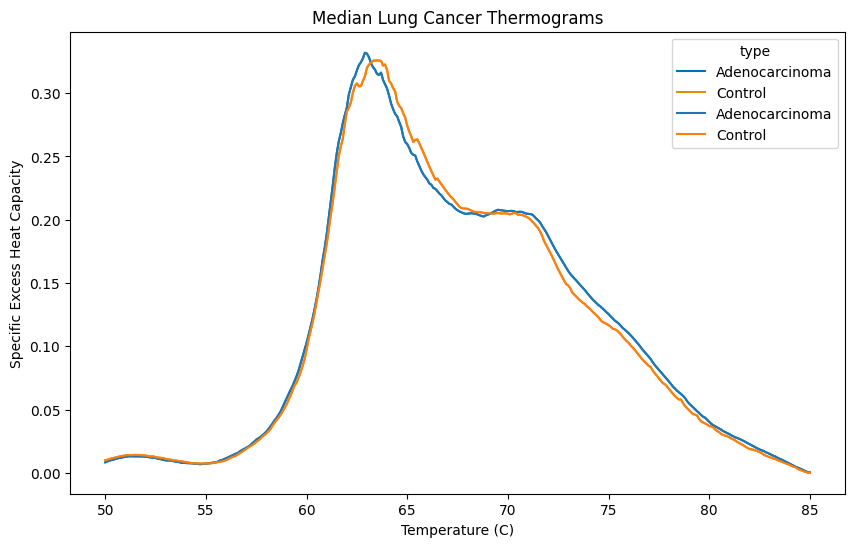

In [5]:
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.lineplot(data=median_df, x='temperature', y='median', hue='type', palette='colorblind')
ax = plt.gca()

# Plot the lines with different colors for 'type'
sns.lineplot(data=median_df, x='temperature', y='median', hue='type')

# Add ribbons for each 'type' with different colors
'''for _, row in median_df.iterrows():
    ax.fill_between([row['temperature']], row['lower_q'], row['upper_q'], alpha=0.3, color='grey')'''

plt.xlabel('Temperature (C)')
plt.ylabel('Specific Excess Heat Capacity')
plt.title('Median Lung Cancer Thermograms')

In [6]:
feature_importance_long = pd.melt(feature_importance, id_vars=['Temperature'], var_name='Fold', value_name='Importance' )
feature_importance.iloc[:, 1:].mean(axis=1)

temps = temps.astype(float)
mean_feature_importance = pd.DataFrame({"Temperature":temps, "Mean Importance": feature_importance.iloc[:, 1:].mean(axis=1)
})

Text(0.5, 1.0, 'Temperature and Importance')

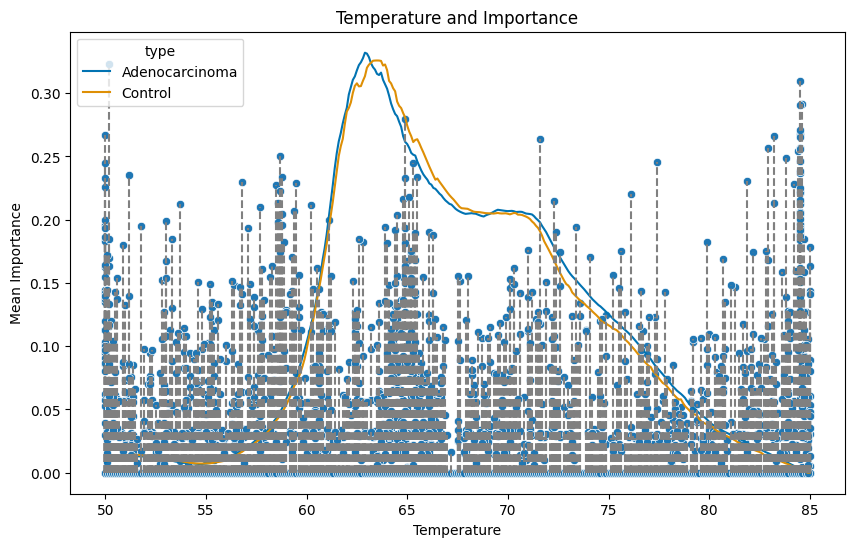

In [7]:
plt.figure(figsize=(10, 6))

# create a bar plot
sns.scatterplot(data=feature_importance_long, x='Temperature', y="Importance")
p = sns.lineplot(data=median_df, x='temperature', y='median', hue='type', palette='colorblind')

for index, row in feature_importance_long.iterrows():
    x_value = row['Temperature']
    y_value = row["Importance"]
    
    # Add a vertical line from the point to the x-axis
    plt.plot([x_value, x_value], [0, y_value], color='gray', linestyle='--')


# add labels and title
plt.xlabel('Temperature')
plt.ylabel('Mean Importance')
plt.title('Temperature and Importance')

Text(0.5, 1.0, 'Temperature and Importance')

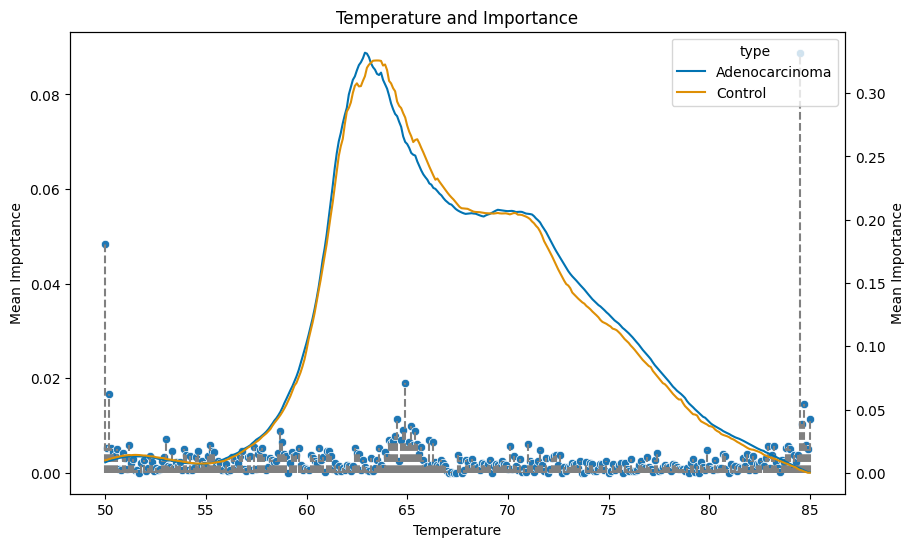

In [8]:
plt.figure(figsize=(10, 6))

# create a bar plot
sns.scatterplot(data=mean_feature_importance, x='Temperature', y="Mean Importance")

for index, row in mean_feature_importance.iterrows():
    x_value = row['Temperature']
    y_value = row["Mean Importance"]
    
    # Add a vertical line from the point to the x-axis
    plt.plot([x_value, x_value], [0, y_value], color='gray', linestyle='--')


ax2 = plt.gca().twinx()

p = sns.lineplot(data=median_df, x='temperature', y='median',ax=ax2, hue='type', palette='colorblind')


# add labels and title
plt.xlabel('Temperature')
plt.ylabel('Mean Importance')
plt.title('Temperature and Importance')

<Axes: ylabel='Weighted Accuracy'>

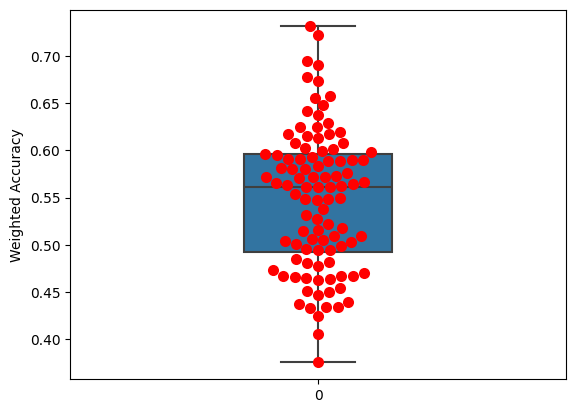

In [9]:
sns.boxplot(data=performance_metrics['Weighted Accuracy'], width=0.3)

# Add points to the boxplot using the swarmplot function
sns.swarmplot(data=performance_metrics['Weighted Accuracy'], color='red', size=8)